In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

os.environ['MKL_NUM_THREADS'] = '4'

In [2]:
data = pd.read_csv('../Lesson_2/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Задание 1. Подбор оптимальных гиперпараметров для ALS

- Попробуйте улучшить базовый вариант ALS, изменяя следующие параметры
  - regularization, iterations
  - factors
  - Вес (TF_IDF, BM25  взвешивание)
  
- Посчитайте метрики (Precision@5, MAP@5) для разных наборов гиперпараметров и выберете лучший набор

In [5]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [6]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [8]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

In [9]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [10]:
def ap_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(0, k):
        
        if flags[i] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i)
            sum_ += p_k
            
    result = sum_ / sum(flags)
    
    return result

In [11]:
%%time

model_01 = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_01.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_02 = AlternatingLeastSquares(factors=100, 
                                regularization=0.005,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_02.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_03 = AlternatingLeastSquares(factors=100, 
                                regularization=0.01,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_03.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_04 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_04.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_05 = AlternatingLeastSquares(factors=100, 
                                regularization=0.1,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_05.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

C:\Users\xiaomi\AppData\Roaming\Python\Python39\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 1min 19s
Wall time: 12.6 s


In [12]:
rec_als_reg = {}

In [13]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_01, sparse_user_item, N=5))
rec_als_reg[model_01.regularization] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_02, sparse_user_item, N=5))
rec_als_reg[model_02.regularization] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_03, sparse_user_item, N=5))
rec_als_reg[model_03.regularization] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_04, sparse_user_item, N=5))
rec_als_reg[model_04.regularization] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_05, sparse_user_item, N=5))
rec_als_reg[model_05.regularization] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()

CPU times: total: 1min 38s
Wall time: 15.3 s


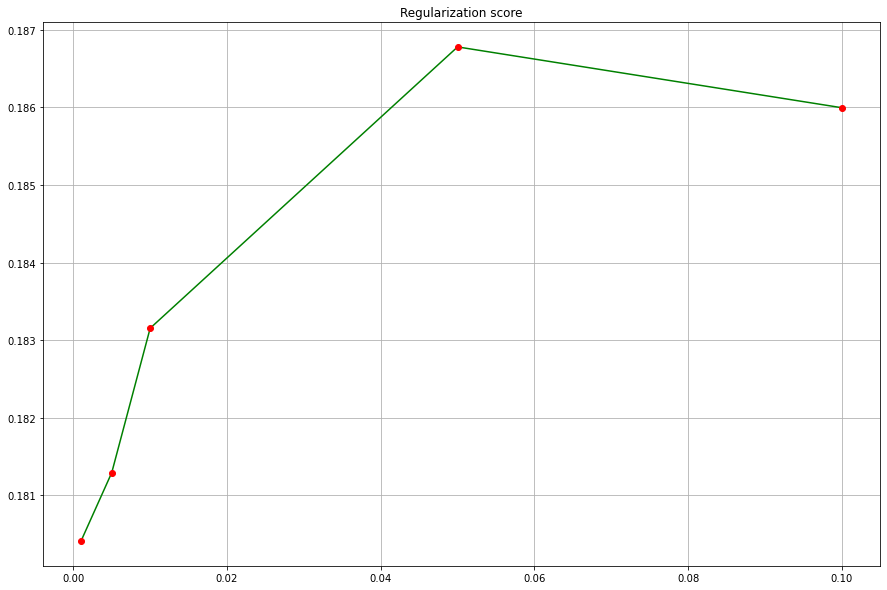

In [14]:
fig, ax = plt.subplots()

ax.plot(*zip(*rec_als_reg.items()),'g')
ax.plot(*zip(*rec_als_reg.items()),'ro')

ax.grid()
ax.set_title('Regularization score')
fig.set_figheight(10)
fig.set_figwidth(15)

In [15]:
print(f'The best score is {max(rec_als_reg.values()):.4f} Regularization = {max(rec_als_reg, key=rec_als_reg.get)}')

The best score is 0.1868 Regularization = 0.05


In [16]:
rec_als_reg

{0.001: 0.18041136141037958,
 0.005: 0.1812928501469123,
 0.01: 0.18315377081292597,
 0.05: 0.18677766895200518,
 0.1: 0.18599412340842053}

In [17]:
%%time

model_01 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_01.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_02 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=2, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_02.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_03 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=3, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_03.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_04 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=4, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_04.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_05 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=5, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_05.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_06 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_06.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_07 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=30, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_07.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_08 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=60, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_08.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_09 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_09.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

model_10 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=200, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_10.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: total: 7min 39s
Wall time: 1min 8s


In [18]:
rec_als_iter = {}

In [19]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_01, sparse_user_item, N=5))
rec_als_iter[model_01.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_02, sparse_user_item, N=5))
rec_als_iter[model_02.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_03, sparse_user_item, N=5))
rec_als_iter[model_03.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_04, sparse_user_item, N=5))
rec_als_iter[model_04.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_05, sparse_user_item, N=5))
rec_als_iter[model_05.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_06, sparse_user_item, N=5))
rec_als_iter[model_06.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_07, sparse_user_item, N=5))
rec_als_iter[model_07.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_08, sparse_user_item, N=5))
rec_als_iter[model_08.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_09, sparse_user_item, N=5))
rec_als_iter[model_09.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_10, sparse_user_item, N=5))
rec_als_iter[model_10.iterations] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()

CPU times: total: 3min 10s
Wall time: 29.5 s


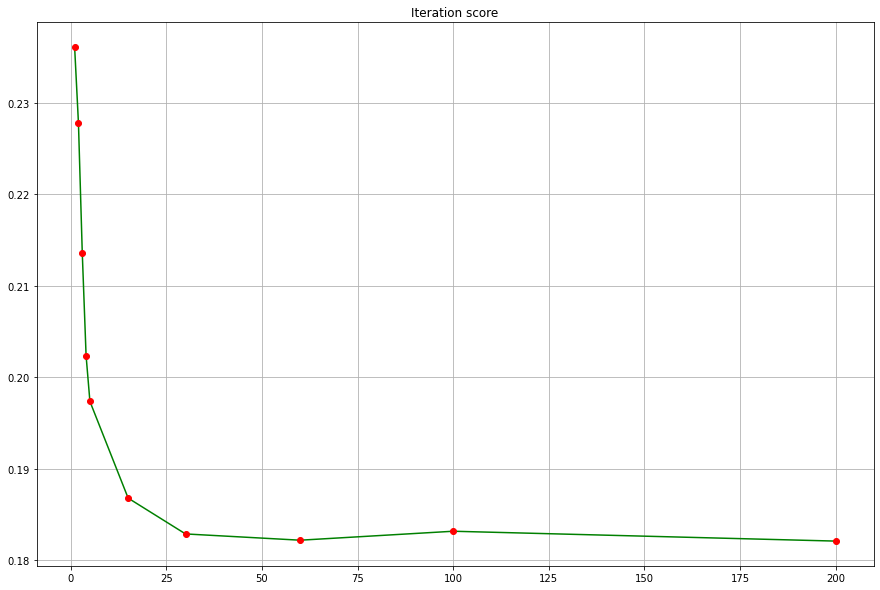

In [20]:
fig, ax = plt.subplots()

ax.plot(*zip(*rec_als_iter.items()),'g')
ax.plot(*zip(*rec_als_iter.items()),'ro')

ax.grid()
ax.set_title('Iteration score')
fig.set_figheight(10)
fig.set_figwidth(15)

In [21]:
print(f'The best score is {max(rec_als_iter.values()):.4f} Iteration = {max(rec_als_iter, key=rec_als_iter.get)}')

The best score is 0.2361 Iteration = 1


In [22]:
rec_als_iter

{1: 0.23614103819784235,
 2: 0.2278158667972549,
 3: 0.21361410381978183,
 4: 0.2023506366307517,
 5: 0.197355533790399,
 15: 0.18677766895200518,
 30: 0.18285994123408156,
 60: 0.182174338883445,
 100: 0.18315377081292597,
 200: 0.18207639569049697}

In [23]:
%%time

model_01 = AlternatingLeastSquares(factors=10, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_01.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_02 = AlternatingLeastSquares(factors=25, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_02.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_03 = AlternatingLeastSquares(factors=50, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_03.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_04 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_04.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_05 = AlternatingLeastSquares(factors=200, 
                                regularization=0.05,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_05.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 1min 17s
Wall time: 12.1 s


In [24]:
rec_als_factor_15 = {}

In [25]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_01, sparse_user_item, N=5))
rec_als_factor_15[model_01.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_02, sparse_user_item, N=5))
rec_als_factor_15[model_02.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_03, sparse_user_item, N=5))
rec_als_factor_15[model_03.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_04, sparse_user_item, N=5))
rec_als_factor_15[model_04.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_05, sparse_user_item, N=5))
rec_als_factor_15[model_05.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()

CPU times: total: 1min 18s
Wall time: 12 s


In [26]:
%%time

model_01 = AlternatingLeastSquares(factors=10, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_01.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_02 = AlternatingLeastSquares(factors=25, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_02.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_03 = AlternatingLeastSquares(factors=50, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_03.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_04 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_04.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_05 = AlternatingLeastSquares(factors=200, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_05.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 6.2 s
Wall time: 1.01 s


In [27]:
rec_als_factor_1 = {}

In [28]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_01, sparse_user_item, N=5))
rec_als_factor_1[model_01.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_02, sparse_user_item, N=5))
rec_als_factor_1[model_02.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_03, sparse_user_item, N=5))
rec_als_factor_1[model_03.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_04, sparse_user_item, N=5))
rec_als_factor_1[model_04.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_05, sparse_user_item, N=5))
rec_als_factor_1[model_05.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()

CPU times: total: 1min 22s
Wall time: 12.1 s


In [29]:
%%time

model_01 = AlternatingLeastSquares(factors=10, 
                                regularization=0.05,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_01.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_02 = AlternatingLeastSquares(factors=25, 
                                regularization=0.05,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_02.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_03 = AlternatingLeastSquares(factors=50, 
                                regularization=0.05,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_03.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_04 = AlternatingLeastSquares(factors=100, 
                                regularization=0.05,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_04.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_05 = AlternatingLeastSquares(factors=200, 
                                regularization=0.05,
                                iterations=100, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_05.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: total: 9min 2s
Wall time: 1min 21s


In [30]:
rec_als_factor_100 = {}

In [31]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_01, sparse_user_item, N=5))
rec_als_factor_100[model_01.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_02, sparse_user_item, N=5))
rec_als_factor_100[model_02.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_03, sparse_user_item, N=5))
rec_als_factor_100[model_03.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_04, sparse_user_item, N=5))
rec_als_factor_100[model_04.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_05, sparse_user_item, N=5))
rec_als_factor_100[model_05.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()

CPU times: total: 1min 20s
Wall time: 12.4 s


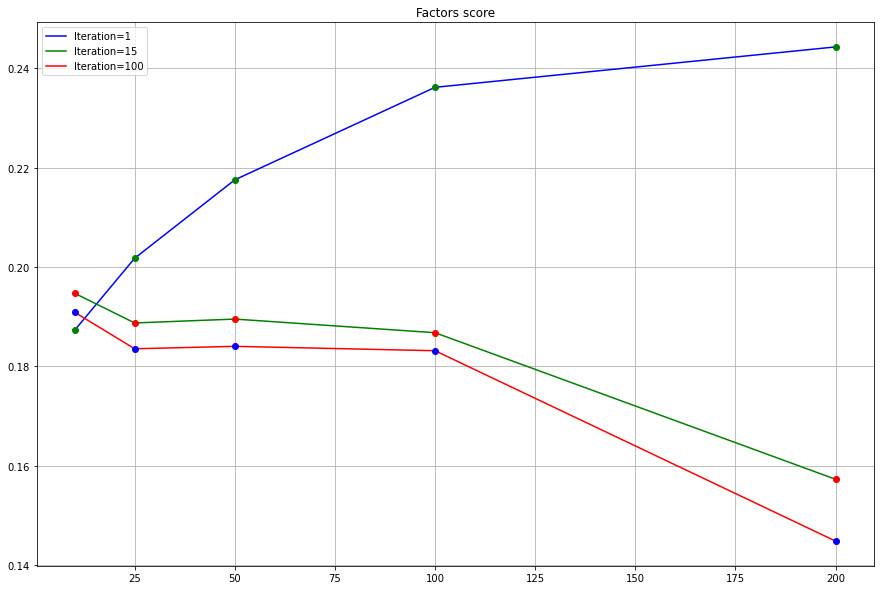

In [32]:
fig, ax = plt.subplots()

ax.plot(*zip(*rec_als_factor_1.items()),'b', label = 'Iteration=1')
ax.plot(*zip(*rec_als_factor_1.items()),'go')
ax.plot(*zip(*rec_als_factor_15.items()),'g', label = 'Iteration=15')
ax.plot(*zip(*rec_als_factor_15.items()),'ro')
ax.plot(*zip(*rec_als_factor_100.items()),'r', label = 'Iteration=100')
ax.plot(*zip(*rec_als_factor_100.items()),'bo')

ax.grid()
ax.legend()
ax.set_title('Factors score')
fig.set_figheight(10)
fig.set_figwidth(15)

In [33]:
print(f'The best score is {max(rec_als_factor_100.values()):.4f} \
      Factors = {max(rec_als_factor_100, key=rec_als_factor_100.get)} Iteration = 100')
print(f'The best score is {max(rec_als_factor_15.values()):.4f} \
      Factors = {max(rec_als_factor_15, key=rec_als_factor_15.get)} Iteration = 15')
print(f'The best score is {max(rec_als_factor_1.values()):.4f} \
      Factors = {max(rec_als_factor_1, key=rec_als_factor_1.get)} Iteration = 1')

The best score is 0.1909       Factors = 10 Iteration = 100
The best score is 0.1947       Factors = 10 Iteration = 15
The best score is 0.2443       Factors = 200 Iteration = 1


In [34]:
%%time

model_01 = AlternatingLeastSquares(factors=200, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_01.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_02 = AlternatingLeastSquares(factors=250, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_02.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_03 = AlternatingLeastSquares(factors=300, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_03.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_04 = AlternatingLeastSquares(factors=350, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_04.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)
model_05 = AlternatingLeastSquares(factors=375, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,random_state=42)

model_05.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 14.7 s
Wall time: 2.26 s


In [35]:
rec_als_factor = {}

In [36]:
%%time
    
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_01, sparse_user_item, N=5))
rec_als_factor[model_01.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_02, sparse_user_item, N=5))
rec_als_factor[model_02.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_03, sparse_user_item, N=5))
rec_als_factor[model_03.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_04, sparse_user_item, N=5))
rec_als_factor[model_04.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()
result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model_05, sparse_user_item, N=5))
rec_als_factor[model_05.factors] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), 
                                                    axis=1).mean()


CPU times: total: 5min 13s
Wall time: 47.1 s


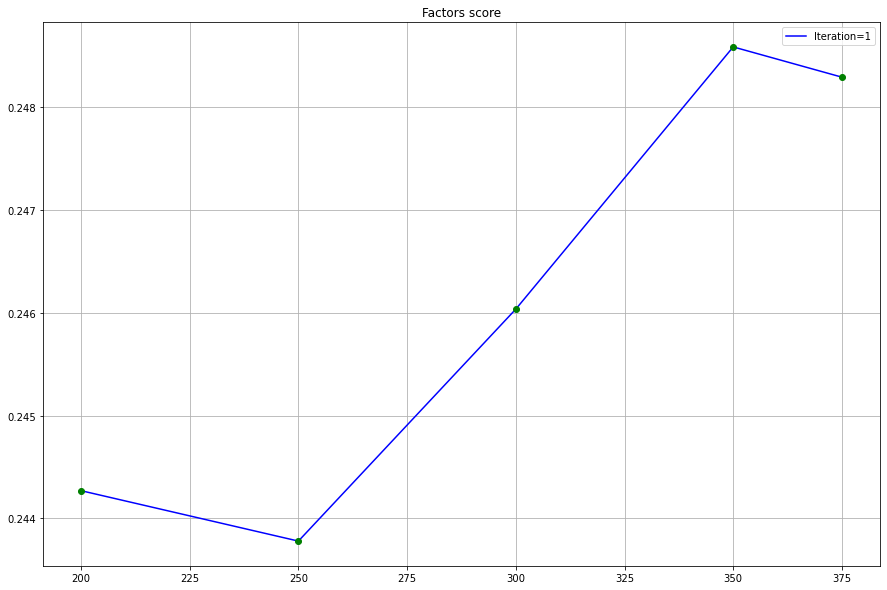

In [37]:
fig, ax = plt.subplots()

ax.plot(*zip(*rec_als_factor.items()),'b', label = 'Iteration=1')
ax.plot(*zip(*rec_als_factor.items()),'go')

ax.grid()
ax.legend()
ax.set_title('Factors score')
fig.set_figheight(10)
fig.set_figwidth(15)

In [38]:
print(f'The best score is {max(rec_als_factor.values()):.4f} \
      Factors = {max(rec_als_factor, key=rec_als_factor.get)}, Iteration = 1, Regularization=0.05')

The best score is 0.2486       Factors = 350, Iteration = 1, Regularization=0.05


#### TF-IDF взвешивание

In [39]:
tfidf_user_item_matrix = tfidf_weight(user_item_matrix.T).T.tocsr() # Применяется к item-user матрице ! 

In [40]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.01,
                                iterations=11, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 22 s
Wall time: 3.39 s


0.19666993143976233

In [41]:
tfidf_user_item_matrix = tfidf_weight(user_item_matrix).tocsr() # Применяется к item-user матрице ! 

In [42]:
%%time

model = AlternatingLeastSquares(factors=50, 
                                regularization=0.01,
                                iterations=11, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 21.2 s
Wall time: 3.43 s


0.24162585700293496

#### BM25 взвешивание

In [43]:
bm25_user_item_matrix = bm25_weight(user_item_matrix).tocsr() # Применяется к item-user матрице !

In [44]:
%%time

model = AlternatingLeastSquares(factors=350, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42) # K - кол-во билжайших соседей

model.fit(csr_matrix(bm25_user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 1min 20s
Wall time: 12.2 s


0.20088148873652997

In [45]:
bm25_user_item_matrix = bm25_weight(user_item_matrix.T).T.tocsr() # Применяется к item-user матрице ! 

In [46]:
%%time

model = AlternatingLeastSquares(factors=350, 
                                regularization=0.05,
                                iterations=1, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42) # K - кол-во билжайших соседей

model.fit(csr_matrix(bm25_user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 1min 23s
Wall time: 12.3 s


0.27218413320274043

### The best score is 0.272